In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid

#--------------------------------------------------
# Read data produced with different settings of kf
#--------------------------------------------------

np_t = [] # list for outputs with settings. invm = numpy.linalg.inv, useKG = True
np_f = [] # invm = np.linalg.inv, useKG = False
bl_t = [] # invm = block_inv, useKG = True
bl_f = [] # invm = block_inv, useKG = False

# block_iter_inv didn't work without Kalman filter with the first simulated dataset (probably, because
# there were only two states and the function tries to divide the number of states into 5 slices), 
# so I'll only use data from simulations 1 to 5 (so not simulation 0)


for i in range(1,6):

    np_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_default_with_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    bl_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_block_with_kf/*.nc",
                        concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    np_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_default_without_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))
    
    bl_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_block_without_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

#------------------------------------------------------------------------------
# Had to read matrices in another way, as open_mfdataset didn't work with them
#----------------------------------------------------------------------------
B_s = [] # prior covariance matrices
A_s = [] # posterior covariance matrices
R_s = [] # observation error covariance matrices
# #for i in range(5):
#     data = xr.open_dataset(f"simulated_data/simulation_05/s05_out_0{i}.nc")
#     B_s.append(data["prior_cov"])
#     A_s.append(data["posterior_cov"])
#     R_s.append(data["obs_unc"])


Observations
---------------------
Observations come unaltered from init data so they should be the same regardless of kf settings


In [56]:
dat = np_t[1]
print(dat["posterior"])

# fig, ax = plt.subplots(layout = 'constrained')
# ax.plot(data["time"], data["obs"].transpose(), color = 'blue', marker = 'o')
# plt.show()

<xarray.DataArray 'posterior' (time2: 5, nstate: 100)>
dask.array<concatenate, shape=(5, 100), dtype=float64, chunksize=(1, 100), chunktype=numpy.ndarray>
Dimensions without coordinates: time2, nstate


Posterior state
----------------

These don't seem to change between time windows or different kf settings. Why?

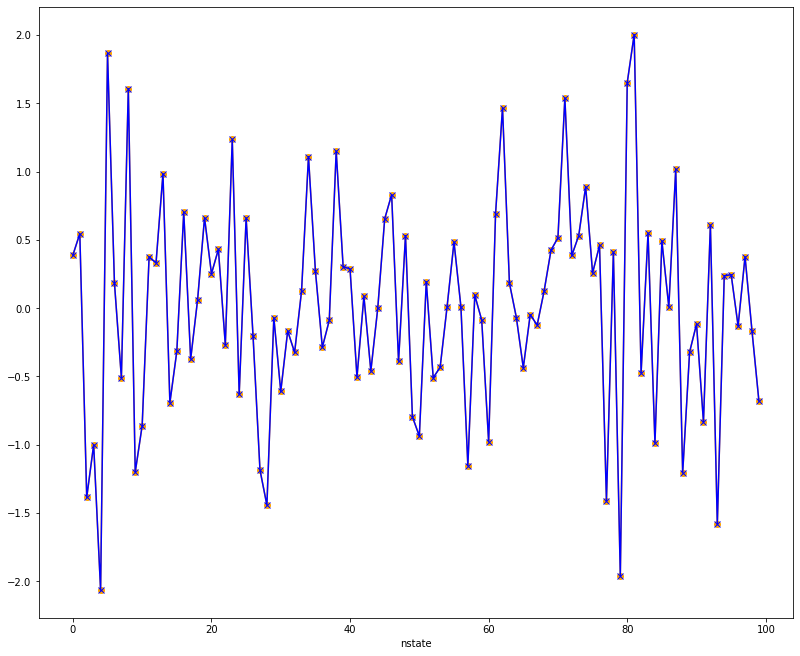

In [69]:
s = 1 # simulation number is s+1

dat1 = np_t[s].posterior
dat2 = bl_t[s].posterior

fig, ax = plt.subplots(layout = 'constrained', figsize = (11,9))
ax.plot(dat1.nstate, dat1[4,:].values, marker = 'o', color = 'orange')
ax.plot(dat2.nstate, dat2[4,:].values, marker = 'x', color = 'blue')
ax.set_xlabel("nstate")

plt.show()


Obs - prior differences
-----------------------
Below plotted for the whole time, including the first time window, in which
differences significantly larger.

Maybe better to exclude the first time window from the plot?

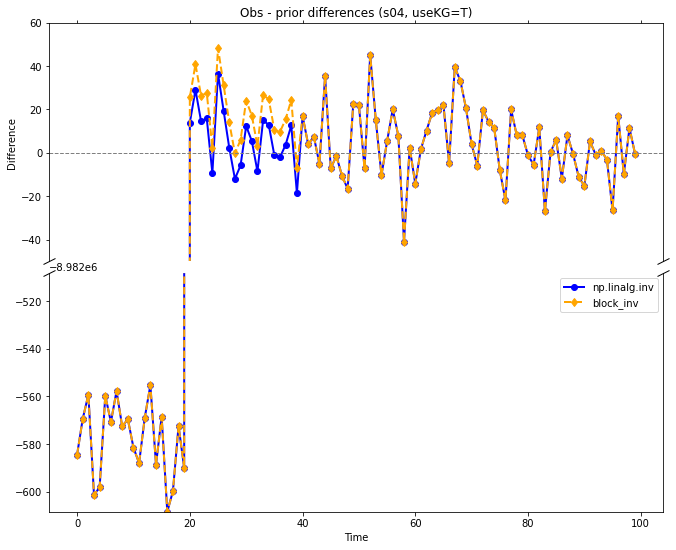

In [86]:
#-----------------------------------------------------
# Change data into a more suitable format for plotting 
#-----------------------------------------------------


# E.g. in s01 data.differences of each timewindow have shape (1,50) even though
# the actual time window is shorter than 50. Let's pick the slice of 
# the total time that corresponds to each time window (shape (1.10)) and 
# recombine these slices into a single dataArray of shape (1,50)

s = 3 # simulation number is s+1
tw = 20 # time window length in the data

da1 = np_t[s].differences 
da2 = bl_t[s].differences
da3 = np_f[s].differences
da4 = bl_f[s].differences 

ls1 = []
ls2 = []
ls3 = []
ls4 = []

for i in range(5):
    ls1.append(da1[i,i*tw:(i+1)*tw])
    ls2.append(da2[i,i*tw:(i+1)*tw])
    ls3.append(da3[i,i*tw:(i+1)*tw])
    ls4.append(da4[i,i*tw:(i+1)*tw])
np_t_dif = xr.concat(ls1, dim = 'time')
bl_t_dif = xr.concat(ls2, dim = 'time')
np_f_dif = xr.concat(ls3, dim = 'time')
bl_f_dif = xr.concat(ls4, dim = 'time')


#--------------------------------------------
# Plot with discontinuous y-axis
#--------------------------------------------

#split y-axis into two by creating two subplots on
# top of each other
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (11,9))
fig.subplots_adjust(hspace=0.05)

# same data on both axes
ax1.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
ax2.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
ax1.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv") 
ax2.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv")

ax1.axhline(y=0,linewidth= 1, color='grey', linestyle= 'dashed')

minval = np_t_dif.min()

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(-50, 60)  # most of the data
ax2.set_ylim(minval, minval+100)  # outliers only

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Time")
ax2.legend()
ax1.set_ylabel("Difference")
ax1.set_title(f"Obs - prior differences (s0{s+1}, useKG=T)")



plt.show()




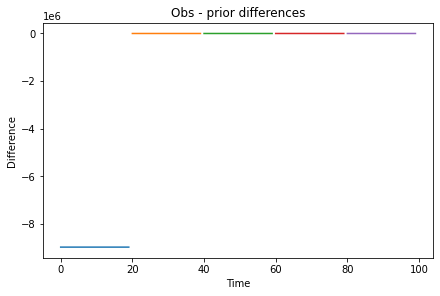

In [31]:
data = np_t[3]
fig, ax = plt.subplots(layout = 'constrained')
ax.plot(data['time'], data['differences'].transpose())
ax.set_ylabel('Difference')
ax.set_xlabel('Time')
ax.set_title('Obs - prior differences')
plt.show()


Posterior means
--------------------



The easiest but ugliest way out: each subplot has its own colorbar, and colorbar ranges differ.


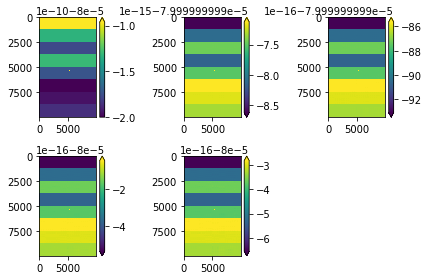

In [3]:

fig, axs = plt.subplots(2,3)
axs[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    A_s[k].plot.imshow(ax = axs[i,j], yincrease = False, robust = True, add_labels = False)
plt.tight_layout()
plt.show()



QUANTILES + SYMLOGNORM

Problem with SymLogNorm: plots a really nice plot but the colormap doesn't center at zero

Colorbar min and max set manually to certain quantiles.
Alfa has to be really small < 10**(-3) 
Otherwise all but the first subplot seem to become uniformly one color
because such an immense part of the values within very small range around zero


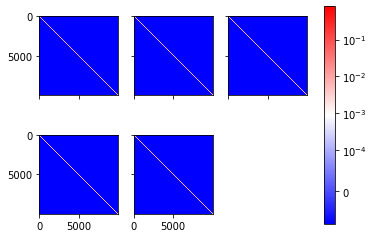

In [24]:

fig, axs = plt.subplots(2,3)
axs[-1,-1].axis('off')

images = []
for k in range(5):
    i = k // 3
    j = k - 3*i
    images.append(axs[i,j].imshow(A_s[k], cmap = 'viridis'))
    axs[i, j].label_outer()

# Find the quantiles to use as colorbar min and max

    
qlower = min(np.quantile(A.values, 10**(-5)) for A in A_s)
qupper = max(np.quantile(A.values, (1-10**(-5))) for A in A_s)
vmin = min(A.values.min() for A in A_s)
vmax = max(A.values.max() for A in A_s)

norm = colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh = 10**(-4))
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm)
plt.show()





How about matshow?



In [ ]:



# fig, axes = plt.subplots(nrows=nr, ncols=nc)
# axes[-1,-1].axis('off')
# for k in range(5):
#     i = k // 3
#     j = k - 3*i
#     im = axes[i,j].matshow(A_s[k])

# fig.colorbar(im, ax=axes.ravel().tolist(), norm = colors.Normalize)

# plt.show()